<a href="https://colab.research.google.com/github/Mkhan13/ai_cybersecurity/blob/Assignment-1/Cybersec_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Hands on with Data Processing and Model Optimization

**Name:** Mariam Khan

In [37]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Part 1: Data Loading & Preprocessing

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
path = "drive/MyDrive/Cybersec/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"

# Load the data
try:
    df = pd.read_csv(path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print("ERROR: File not found.")

Data loaded successfully!


In [40]:
# Handle missing and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.columns = df.columns.str.strip(' ')

In [41]:
# Focus on infiltration attack
df = df[df['Label'].isin(['BENIGN', 'Infiltration'])]
df['Label'].value_counts()

,count
Label,
BENIGN,288359
Infiltration,36


In [42]:
# Port frequency encoding
port_freq = df['Destination Port'].value_counts()
df['DestPort_Freq'] = df['Destination Port'].map(port_freq)

df.drop(columns=['Destination Port'], inplace=True)

In [43]:
# Train/test split
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # 70/30 split

### Part 2: Visual Feature Analysis

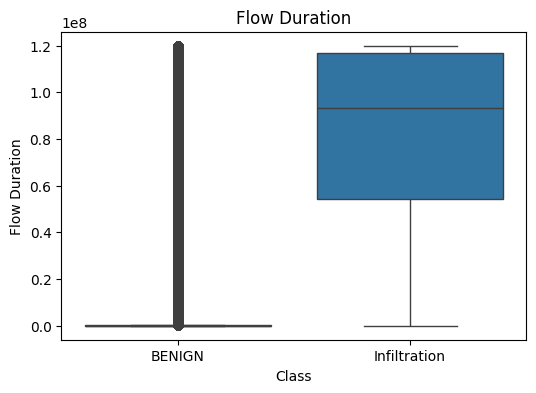

In [44]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['Flow Duration'])
plt.title('Flow Duration')
plt.xlabel('Class')
plt.ylabel('Flow Duration')
plt.show()

The flow duration box plot shows that the infiltration attack traffic flow lasts longer than the benign traffic flow. I believe that this is because the attacker needs a longer connection to execute the attack.

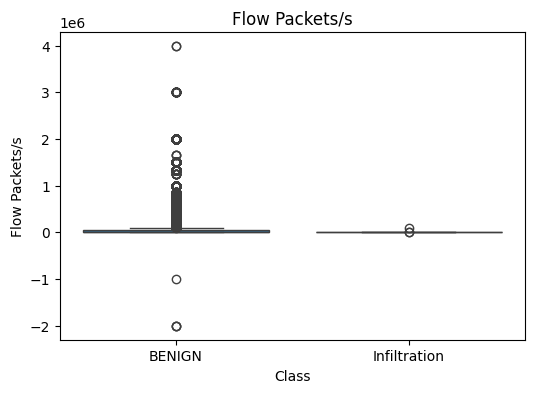

In [45]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['Flow Packets/s'])
plt.title('Flow Packets/s')
plt.xlabel('Class')
plt.ylabel('Flow Packets/s')
plt.show()

The plot shows that the benign traffic type has significantly higher traffic flow compared to the infiltration attack type. I believe this is because the attackers executing the infiltration attack use a lower rate of packet flow to avoid detection.

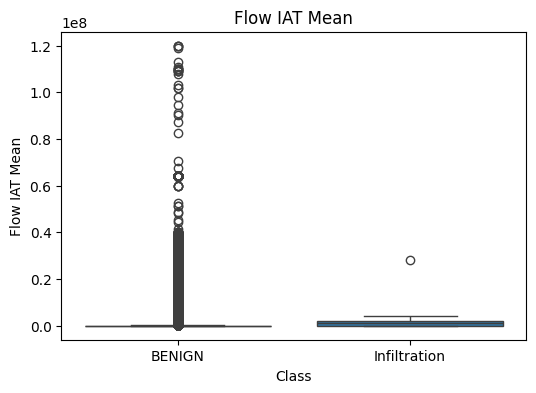

In [46]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['Flow IAT Mean'])
plt.title('Flow IAT Mean')
plt.xlabel('Class')
plt.ylabel('Flow IAT Mean')
plt.show()

This boxplot shows that the benign traffic has a significantly higher inter arrival time with much more variation (outliers). I believe that the benign traffic has more variation because it is showing human traffic patterns with pauses between requests while the infiltration flow is more compressed because it is likely run by an automated script.

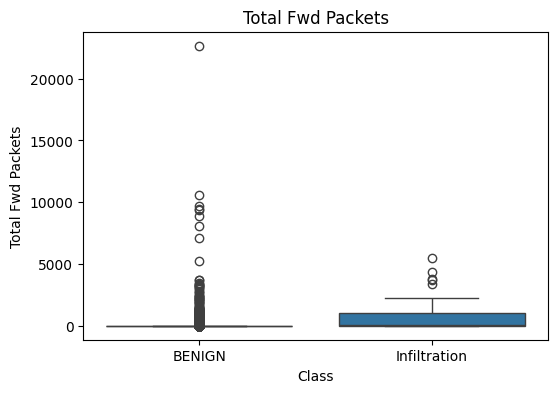

In [47]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['Total Fwd Packets'])
plt.title('Total Fwd Packets')
plt.xlabel('Class')
plt.ylabel('Total Fwd Packets')
plt.show()

This plot shows that the infiltration attack has a more uniform number of forward packets compared to the benign traffic. I believe this is because the infiltration attack has more automated traffic patterns while the benign traffic has more human variation in request volume.

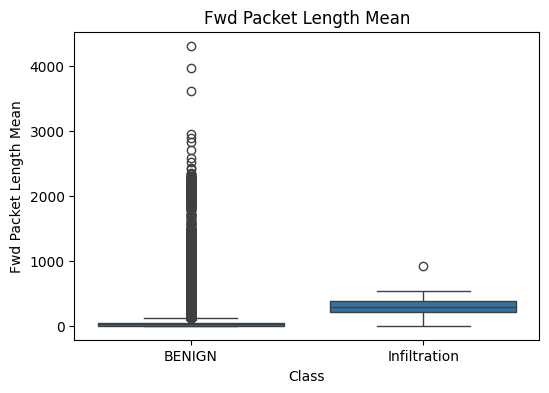

In [48]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['Fwd Packet Length Mean'])
plt.title('Fwd Packet Length Mean')
plt.xlabel('Class')
plt.ylabel('Fwd Packet Length Mean')
plt.show()

This bioxplot shows that the infiltration attack has a more similarly sized packet length compared to the benign traffic. I believe this is because the infiltration attack has more automated packet sizes while the benign traffic has more human variation in packet length.

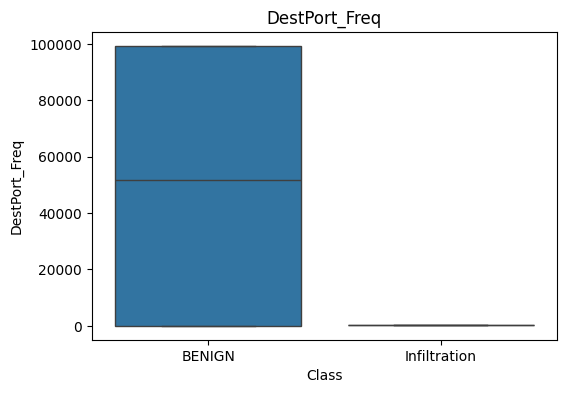

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Label'], y=df['DestPort_Freq'])
plt.title('DestPort_Freq')
plt.xlabel('Class')
plt.ylabel('DestPort_Freq')
plt.show()

This plot shows that the benign traffic has an extremely high destination port frequency compared to the infiltration traffic. I believe this large range is because of the wide variety of services human users connect to compared to attackers who focus on specific ports for their attack

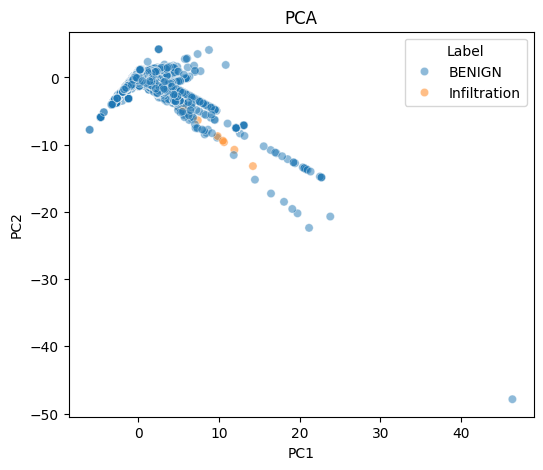

In [50]:
# PCA
features = [
    'Flow Duration',
    'Flow Packets/s',
    'Flow IAT Mean',
    'Total Fwd Packets',
    'Fwd Packet Length Mean',
    'DestPort_Freq'
]

X = df[features]
y = df['Label']

scaler = StandardScaler() #Initilize scaler
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2) # Apply PCA
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, alpha=0.5)
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


**Evaluate:** This PCA graph shows poor class separability. The benign and infiltration classes overlap significantly especially where PC1 is beween -5 to 10 and PC2 is between -10 and 0. The benign data points are densly clustered while the infiltration data points are more dispersed.   

</br>  

**Interpret:** This aligns with expected attack signatures. Infiltration attacks are meant to be stealthy and blend in with normal traffic to avoid detection. The overlap in benign and infiltration classes shows that the infiltration attack data shares many features with the benign traffic so it is blending in well.

### Part 3: Scaling Exploration

In [36]:
features = [ # Top 5 features
    'Flow Duration',
    'Flow Packets/s',
    'Flow IAT Mean',
    'Total Fwd Packets',
    'DestPort_Freq'
]

benign_mask = (y_train == 'BENIGN') # Check for all benign data
X_benign = X_train.loc[benign_mask, features] # Locate benign baseline data

# Apply scalers
std_scaler = StandardScaler().fit(X_benign)
rob_scaler = RobustScaler().fit(X_benign)

# Transform training dataset
X_train_std = std_scaler.transform(X_train[features])
X_train_rob = rob_scaler.transform(X_train[features])

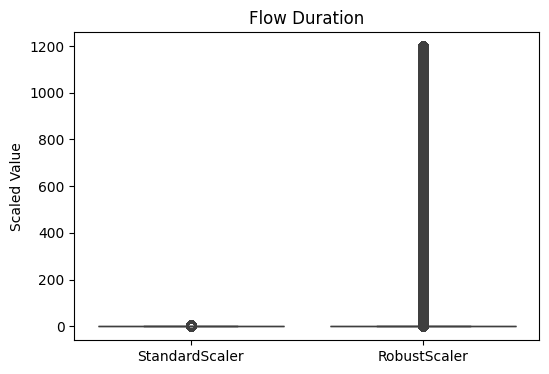

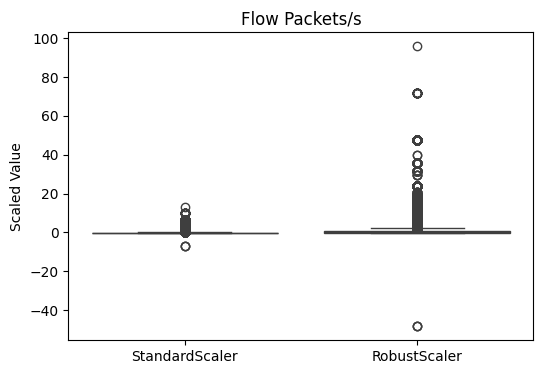

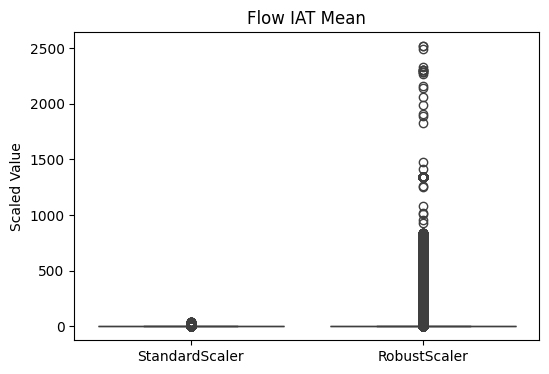

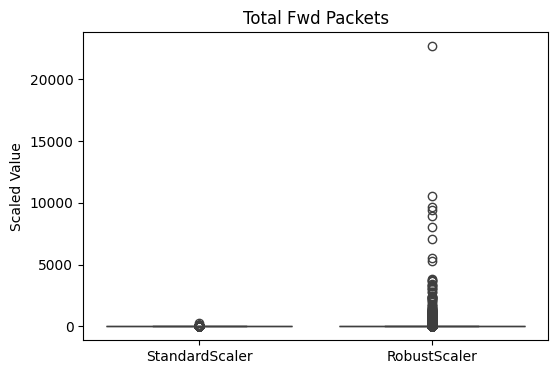

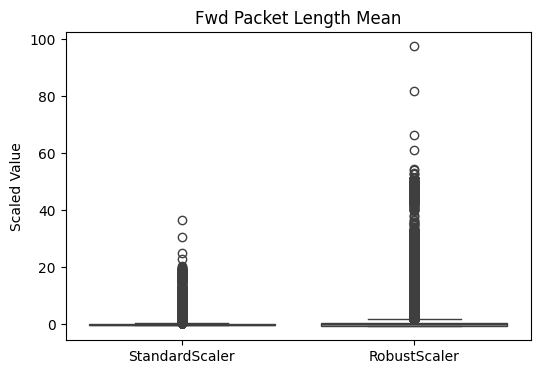

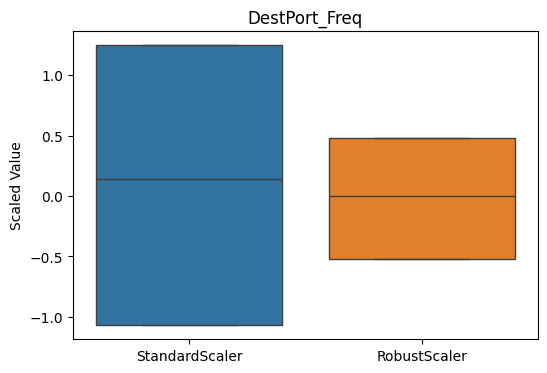

In [54]:
for i, feature in enumerate(features): # Iterate through feature array
    plt.figure(figsize=(6,4))

    sns.boxplot(data=[X_train_std[:, i], X_train_rob[:, i]])

    plt.xticks([0, 1], ['StandardScaler', 'RobustScaler'])
    plt.title(f"{feature}")
    plt.ylabel("Scaled Value")
    plt.show()

**Identify skewness:**  Flow Duration, Flow IAT Mean, Total Fwd Packets, and Fwd Packet Length Mean are all heavily skewed. They all have severe outliers in the data. Robust Scalar preserves better separation because it distributes the data over a wider range while StandardScalar compresses the data closer to 0.

**Document:** For the heavily skewed features listed above, RobustScaler works best as it uses the median and IQR instead of the mean ans standard deviation. This prevents the extreme outliers from impacting the scaling.
For the symmetric feature, DestPort_Freq, both both both of the scalers perform similarly with no outliers.

**Critical thinking:** In production IDS scenarios, we fit only on benign data because the attack data is what we are trying to detect. If the attack data is used in scalar fitting, the anomolies are normalized and there are less differences between the benign and attack data.

### Part 4: Feature Insights Summary

| Feature Name | Most Discriminative? | Skewed Distribution? | Best Scaler | Cybersecurity Explanation |
|---|---|---|---|---|
| Flow Duration | Yes | Yes | RobustScaler | Infiltration attack traffic flow lasts longer than benign traffic because the attacker needs a longer connection to execute the attack |
| Flow Packets/s | Somewhat | Yes | RobustScaler | Attackers executing the infiltration attack use a lower rate of packet flow to avoid detection compared to benign traffic |
| Flow IAT Mean | Yes | Yes | RobustScaler | Benign traffic shows human traffic patterns with pauses between requests while infiltration traffic is more compressed because it is probably run by an automated script |
| Total Fwd Packets | Yes | Yes | RobustScaler | Infiltration attack has more automated traffic patterns while benign traffic has more human variation in request volume |
| Fwd Packet Length Mean | Somewhat | Yes | RobustScaler | Infiltration attack has more automated packet sizes while benign traffic has more human variation in packet length |
| DestPort_Freq | Yes | No | StandardScaler | Benign traffic shows wide variety of services that human users connect to while the attackers focus on specific ports for their attack |

### Part 5: Reflection & Critical Thinking

**Top 3 Discriminative Features:**
1. **Flow Duration:** Infiltration attacks need longer connections to execute the attak which creates distinctly longer session duration compared to the benign traffic
2. **Flow IAT Mean:** Attackers used automated scripts which produce uniform traffic patterns while the benign traffic has more human natural pauses
3. **Flow Packet/s:** Attackers executing the infiltration attack use a lower rate of packet flow to avoid detection compared to benign traffic

**Surprises:** I was surprised by the Flow IAT Mean. I expected attacks to have a higher variation to try to avoid detection. Instead, automated scripts actually create more consistent timing patterns than the benign human behavior.

**Attack Alignment:** The visual analysis matches the known characteristics of an infiltration attack. The graphs showed that the attack used longer connections to execute the attack and low packet rates to avoid detection. The traffic patterns were more uniform which indicated an automated script was executed.

**Scaling Impact:** RobustScaler handled skewness best for my dataset by using median and IQR instead of mean and standard deviation which made it better at handeling the extreme outliers in the traffic.

**Detection Feasibility:** Classification would be difficult for this dataset. The PCA graph shows significant overlap between the benign and infiltration traffic patterns. Infiltration attacks are meant to be stealthy and blend in with normal traffic to avoid detection. The challange would be identifying features that show significant difference between the classes when the data is intentionally blending in.

**Production Considerations:** For real-world IDS, it is critical to fit scalers only on benign data because the attack data is what we are trying to detect. If the attack data is used in scalar fitting, the anomolies in the data are normalized and there are less differences between the benign and attack data.